In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import cv2
import uuid
import datetime
import numpy as np
import compress_pickle as cpkl

from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class
from ss_baselines.common.utils import plot_top_down_map

# Helper / tools
from soundspaces.mp3d_utils import CATEGORY_INDEX_MAPPING
def get_category_name(idx):
    assert idx >= 0 and idx <=20, f"Invalid category index number: {idx}"

    for k, v in CATEGORY_INDEX_MAPPING.items():
        if v == idx:
            return k

def get_current_ep_category_label(obs_dict):
    return get_category_name(obs_dict["category"].argmax())

def dict_without_keys(d, keys_to_ignore):
    return {x: d[x] for x in d if x not in keys_to_ignore}

/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_DIR_PATH = f"SAVI_Oracle_Dataset_v0"
# DATASET_DIR_PATH = f"SAVI_Oracle_Dataset_v0_10K" # Smaller scale dataset for tests

# Read the dataset statistics file.
dataset_stats_filepath = f"{DATASET_DIR_PATH}/dataset_statistics.bz2"
with open(dataset_stats_filepath, "rb") as f:
    r__dataset_stats = cpkl.load(f)

from pprint import pprint
pprint(dict_without_keys(r__dataset_stats, ["cat_scene_filenames", "scene_cat_filenames", "episode_lengths"]))

{'action_cel_coefs': {0: 4.31017895934623,
                      1: 0.3680092679824768,
                      2: 2.1379496126019806,
                      3: 1.7154708643262975},
 'action_counts': {0: 29001, 1: 339664, 2: 58467, 3: 72866},
 'action_probs': {0: 0.05800223200892803,
                  1: 0.6793307173228693,
                  2: 0.11693446773787095,
                  3: 0.14573258293033173},
 'category_counts': {'bathtub': 81,
                     'bed': 661,
                     'cabinet': 2643,
                     'chair': 7432,
                     'chest_of_drawers': 717,
                     'clothes': 151,
                     'counter': 816,
                     'cushion': 2687,
                     'fireplace': 240,
                     'gym_equipment': 78,
                     'picture': 3455,
                     'plant': 1614,
                     'seating': 866,
                     'shower': 288,
                     'sink': 959,
                     'sofa': 

In [3]:
[r__dataset_stats["action_cel_coefs"][a] * r__dataset_stats["action_probs"][a] for a in range(4)]

[0.25, 0.25, 0.24999999999999997, 0.25]

### Plotting some stats about the dataset

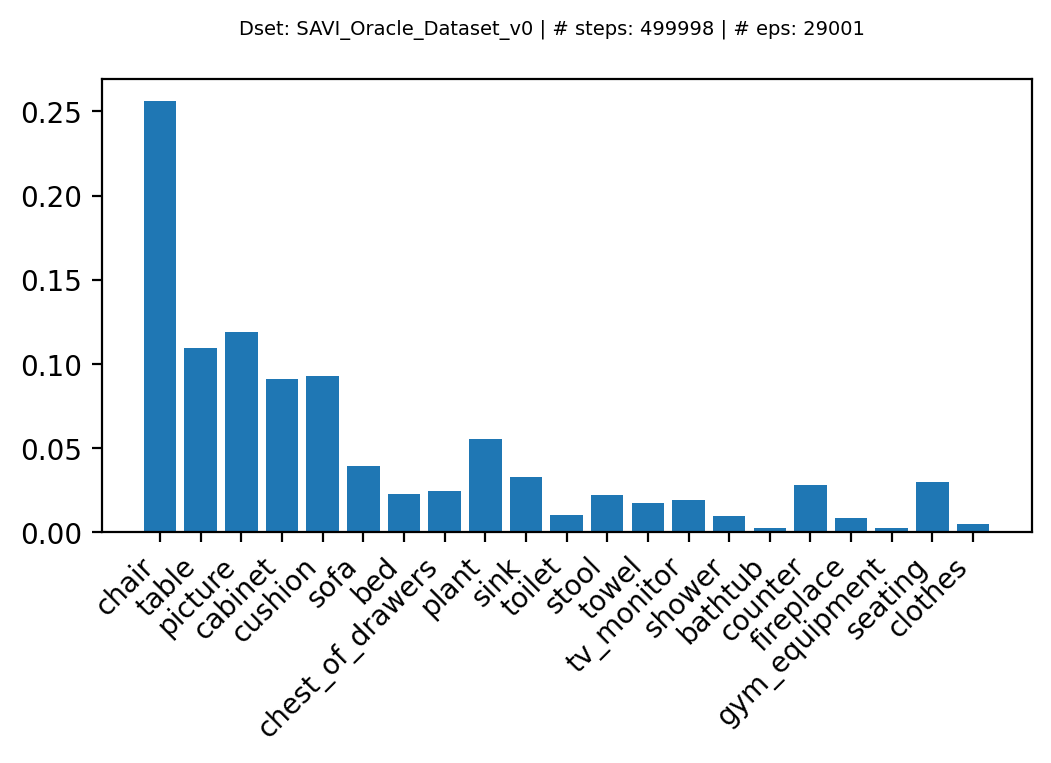

In [4]:
# Frequency of category counts
total_episodes = np.sum([v for k, v in r__dataset_stats["category_counts"].items()])
assert total_episodes == r__dataset_stats["total_episodes"], \
    "Category counts not matching episode counts."

category_probs = {k: v / total_episodes for k, v in r__dataset_stats["category_counts"].items()}
# pprint(category_probs)

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=200)
x=[i for i in range(21)]
x_labels, x_heights = [], []
for k, v in category_probs.items():
    x_labels.append(k)
    x_heights.append(v)
ax.bar(x=x, height=x_heights, tick_label=x_labels)
ax.set_xticklabels(x_labels, rotation=45, ha="right")
fig.suptitle(f"Dset: {DATASET_DIR_PATH} | # steps: {r__dataset_stats['total_steps']} | # eps: {r__dataset_stats['total_episodes']}", fontsize=7)
fig.show()

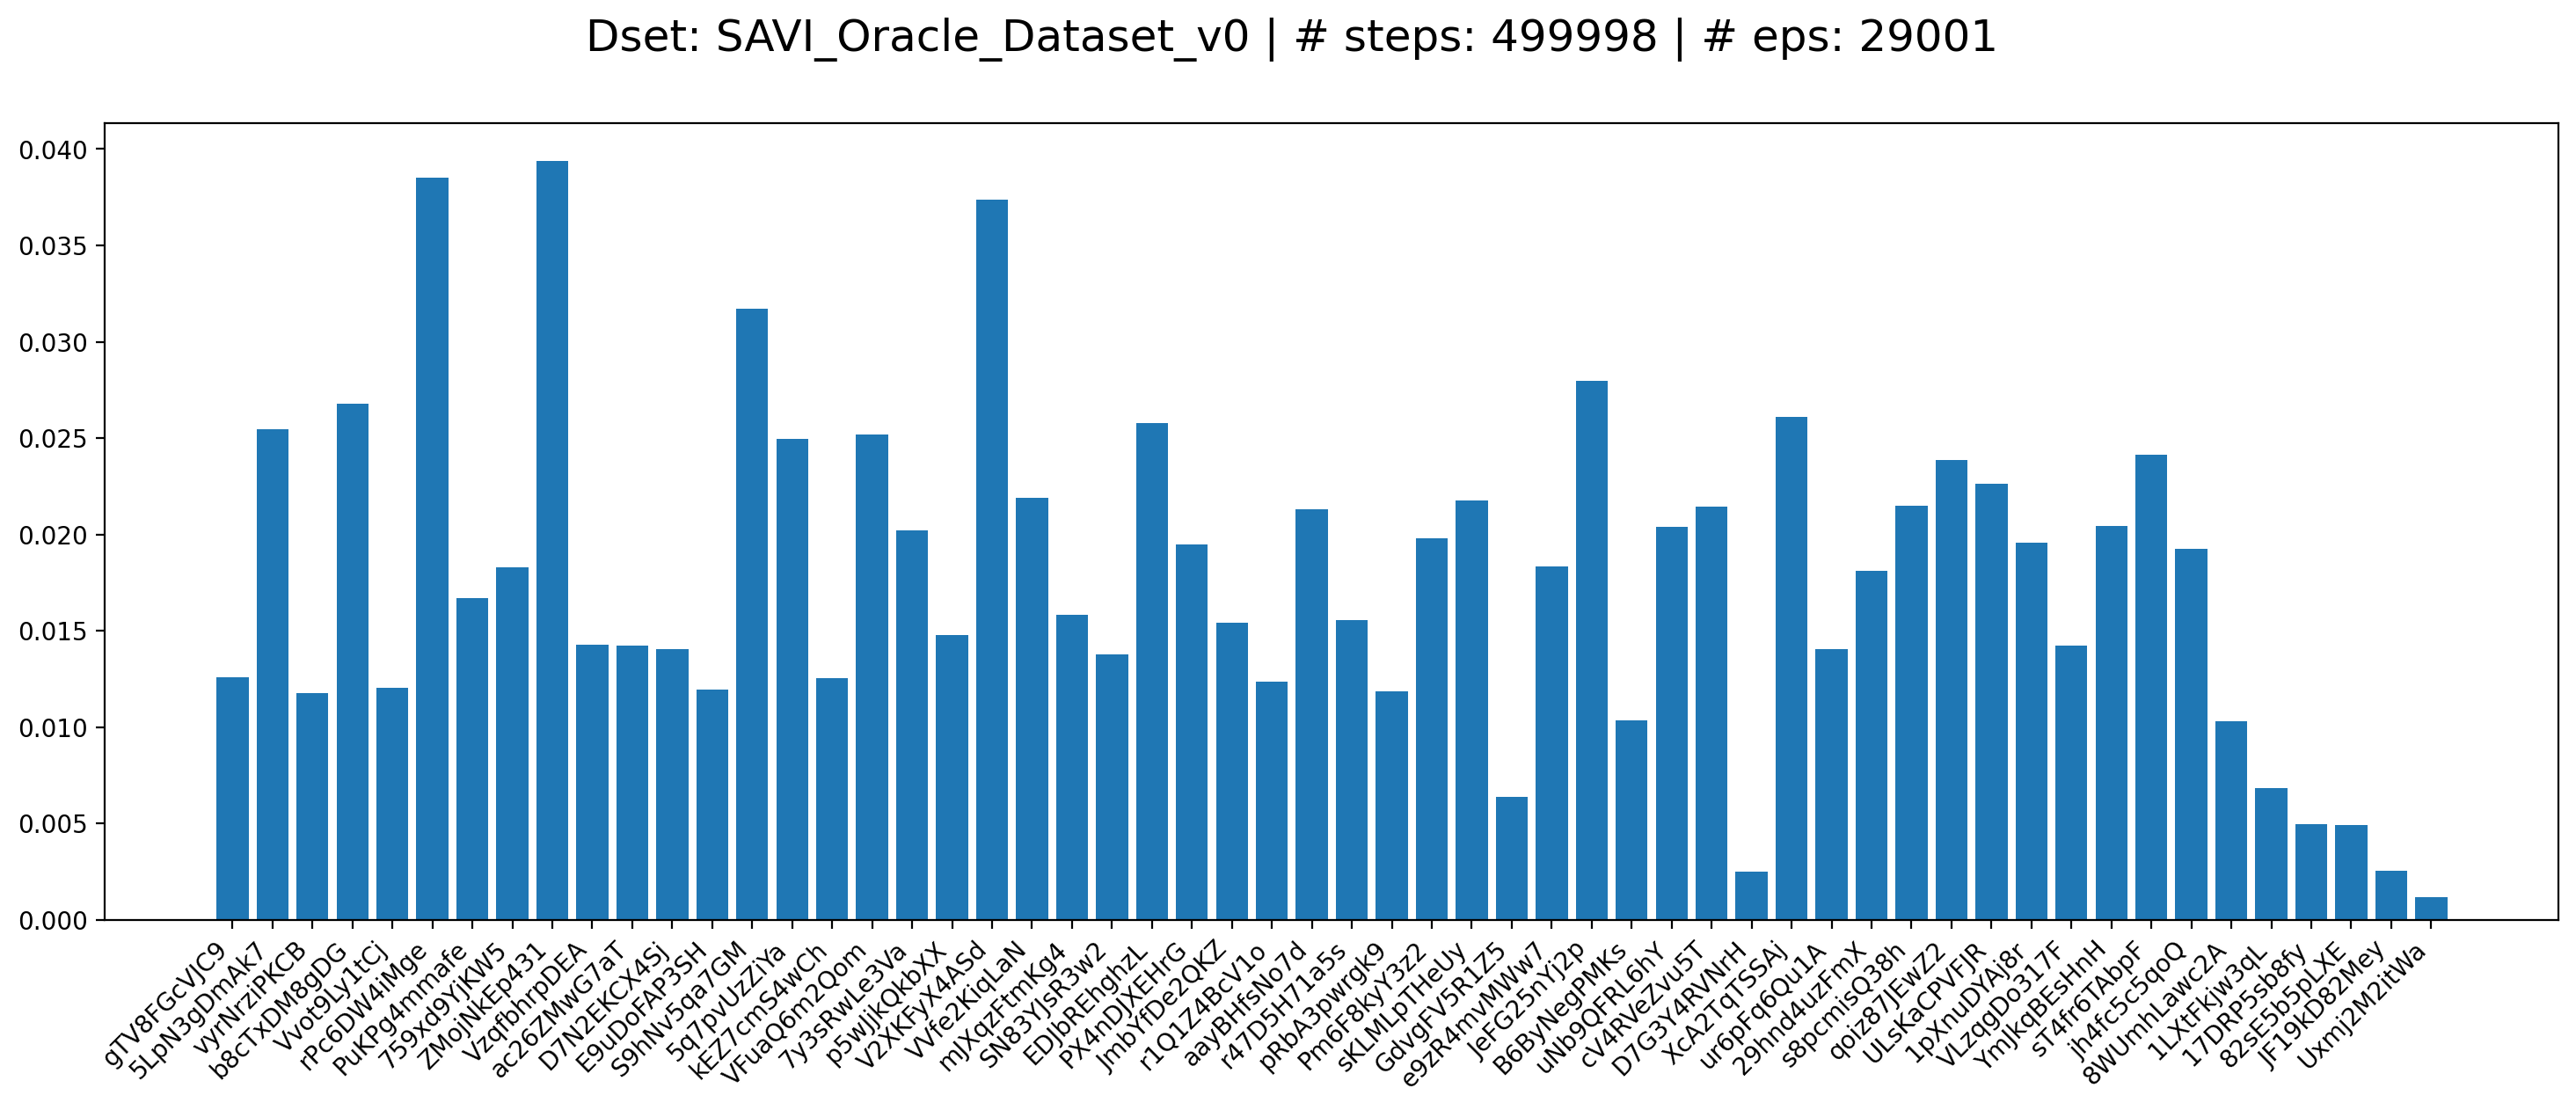

In [5]:
# Frequency of scenes in the dataset
total_episodes = np.sum([v for k, v in r__dataset_stats["scene_counts"].items()])
assert total_episodes == r__dataset_stats["total_episodes"], \
    "Scene counts not matching episode counts."
scene_probs = {k: v / total_episodes for k, v in r__dataset_stats["scene_counts"].items()}

fig, ax = plt.subplots(1,1, figsize=(6 * 3, 6), dpi=200)
x_labels, x_heights = [], []
for k, v in scene_probs.items():
    x_labels.append(k)
    x_heights.append(v)
n_scenes = len(x_labels)
x = [i for i in range(n_scenes)]

ax.bar(x=x, height=x_heights, tick_label=x_labels)
ax.set_xticklabels(x_labels, rotation=45, ha="right")
fig.suptitle(f"Dset: {DATASET_DIR_PATH} | # steps: {r__dataset_stats['total_steps']} | # eps: {r__dataset_stats['total_episodes']}", fontsize=18)
fig.show()

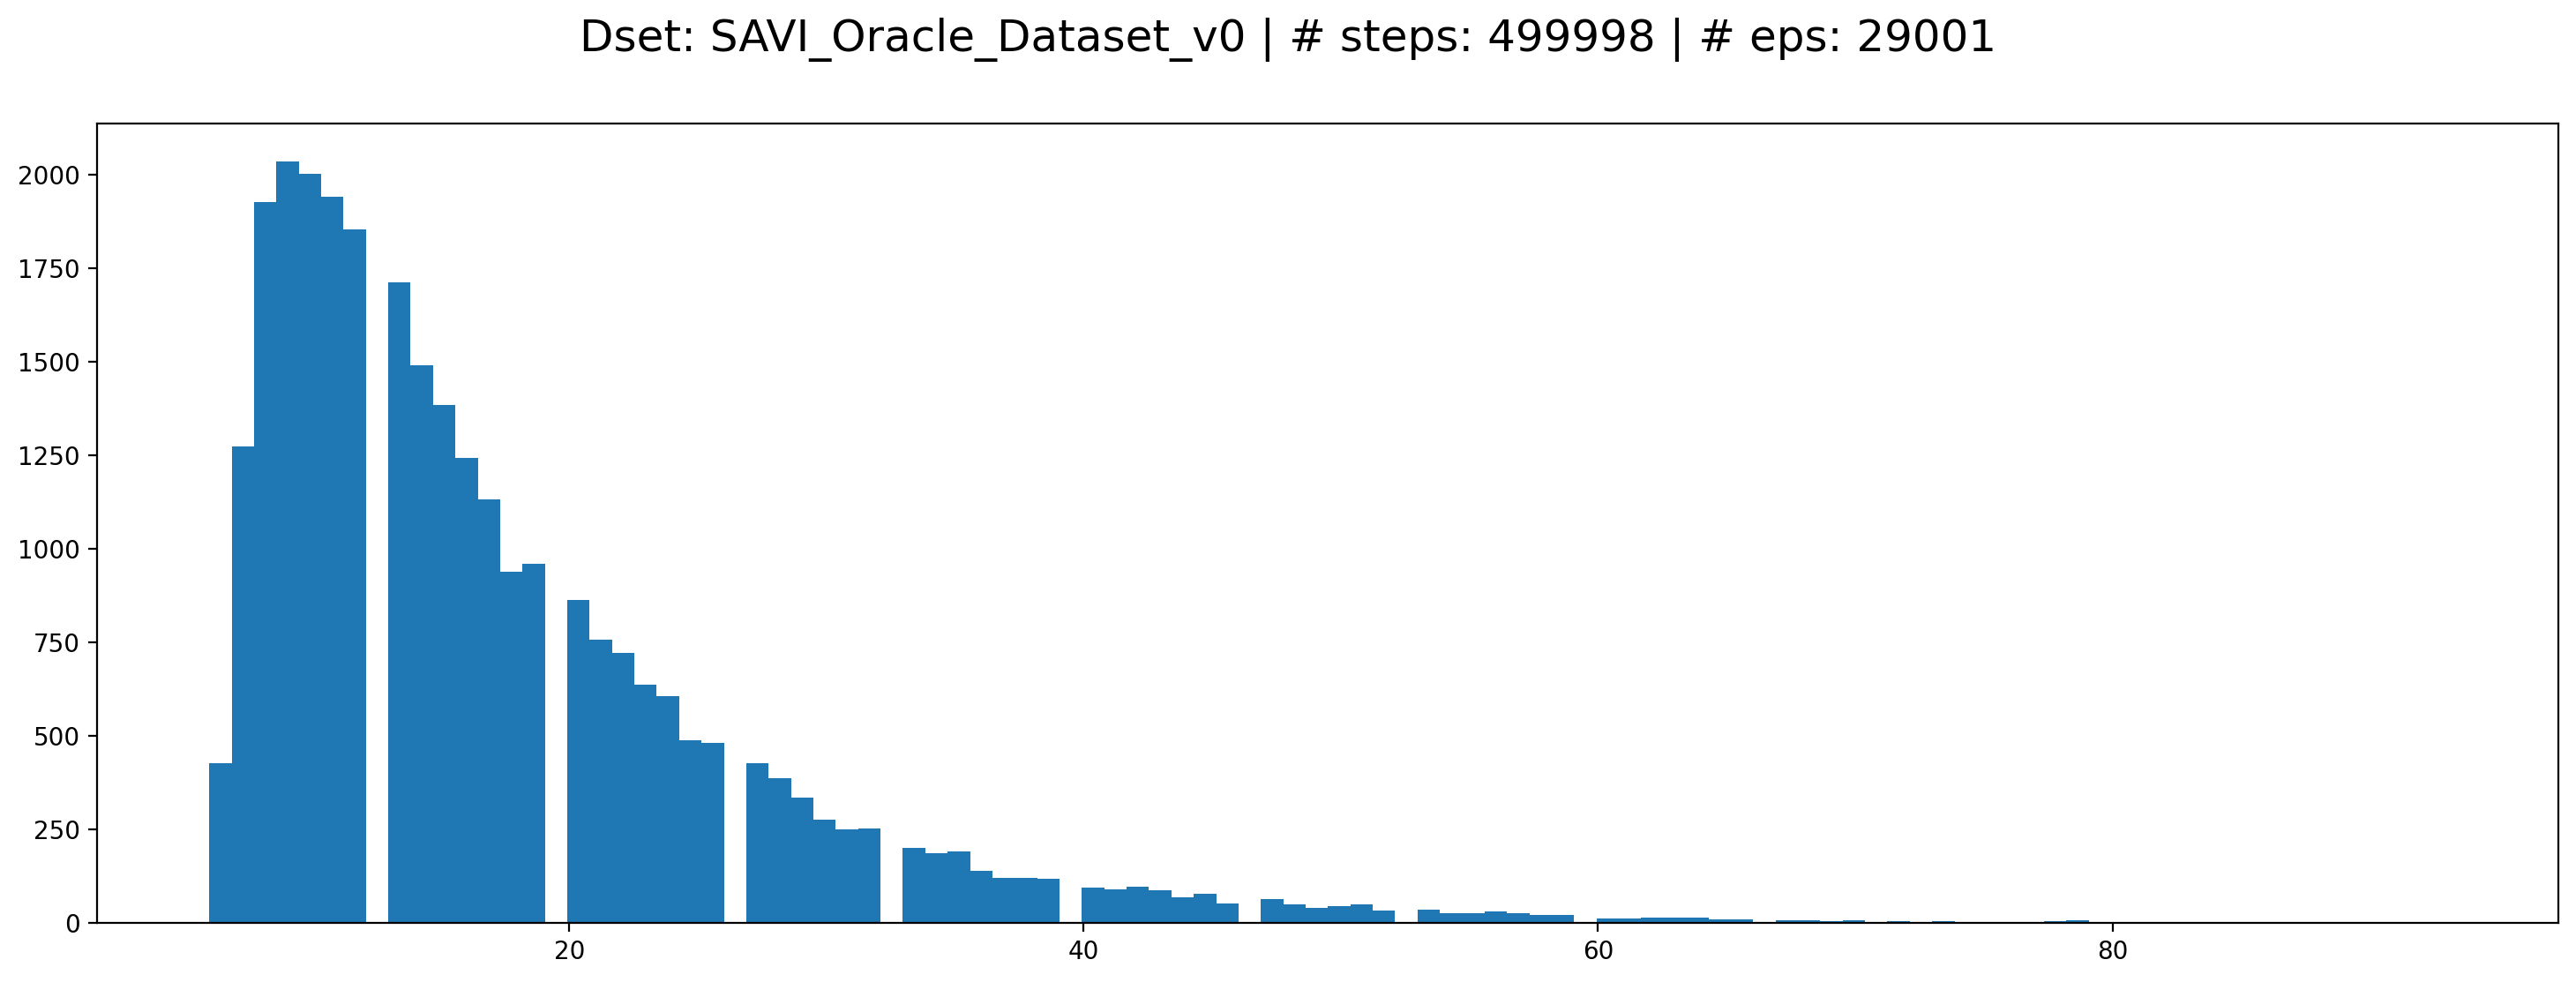

In [6]:
# Frequency of episode lengths / historgram
fig, ax = plt.subplots(1,1, figsize=(6 * 3, 6), dpi=200)
ax.hist(r__dataset_stats["episode_lengths"], bins=100)
fig.suptitle(f"Dset: {DATASET_DIR_PATH} | # steps: {r__dataset_stats['total_steps']} | # eps: {r__dataset_stats['total_episodes']}", fontsize=18)
fig.show()

In [7]:
# # Frequency of the episode lengths
# all_ep_lengths = []
# ep_lengths_dict = {}
# for ep_filename in os.listdir(DATASET_DIR_PATH):
#     if ep_filename == "dataset_statistics.bz2":
#         continue
#     ep_filepath = f"{DATASET_DIR_PATH}/{ep_filename}"
#     with open(ep_filepath, "rb") as f:
#         edd = cpkl.load(f)
    
#     ep_length = edd["ep_length"]
#     if ep_length not in list(ep_lengths_dict.keys()):
#         ep_lengths_dict[ep_length] = 1
#     else:
#         ep_lengths_dict[ep_length] += 1
#     all_ep_lengths.append(ep_length)

# # Histogram of the episodes lengths, note that it is very time costly, since this was not logged during data collection.
# fig, ax = plt.subplots(1,1, figsize=(6 * 3, 6), dpi=200)
# ax.hist(all_ep_lengths, bins=60)

### Populating the category -> scenes -> trajectory list dictionary for RSA

In [8]:
## Filter the files
from IPython.display import clear_output

# Check the category -> scene -> filenames
CATEGORIES_OF_INTEREST = [
    "chair",
    "picture",
    "table",
    "cushion",
    "cabinet",
    "plant"
]

SCENES_OF_INTEREST = [] # To make sure we have the same scenes for each category

# Start byreading all the episodes in 
M = 5 # number fo scenes / rooms, for one category
N = 5 # number of trajs. per scenes / rooms, for one category
C = len(CATEGORIES_OF_INTEREST)

In [ ]:
TRAJS_SCENES_CATS = {
    k: {} for k in CATEGORIES_OF_INTEREST
}

for category, scene_filenames in r__dataset_stats["cat_scene_filenames"].items():
    if category not in CATEGORIES_OF_INTEREST:
        continue

    print(f"{category}:")
    for scene, filenames in scene_filenames.items():
        # Track which scenes' trajectories will be saved.
        # We want the same scenes for each category
        if len(SCENES_OF_INTEREST) < M and (scene not in SCENES_OF_INTEREST):
            SCENES_OF_INTEREST.append(scene)
        
        if scene not in SCENES_OF_INTEREST:
            continue
        
        print(f"\t{scene}: {len(filenames)}")
        
        if scene not in TRAJS_SCENES_CATS[category].keys():
            TRAJS_SCENES_CATS[category][scene] = []
        
        for ep_filename in filenames:
            ep_filepath = f"{DATASET_DIR_PATH}/{ep_filename['ep_filename']}"
            with open(ep_filepath, "rb") as f:
                edd = cpkl.load(f)
            
            TRAJS_SCENES_CATS[category][scene].append({
                "ep_filename": ep_filename,
                "edd": edd
            })

            if len(TRAJS_SCENES_CATS[category][scene]) >= M:
                print(f"\tCollected {len(TRAJS_SCENES_CATS[category][scene])}")
                print("")
                break

In [ ]:
pprint(TRAJS_SCENES_CATS)

# (Deprecated) Extracting trajectories for RSA

### A. C categories, for a given category: N trajs for M rooms

In [ ]:
# from IPython.display import clear_output

# # Start byreading all the episodes in 
# M = 3 # number fo scenes / rooms, for one category
# N = 4 # number of trajs. per scenes / rooms, for one category
# CATEGORIES_OF_INTEREST = [
#     "chair",
#     "picture",
#     # "table",
#     # "cushion",
#     # "cabinet",
#     # "plant"
# ]
# C = len(CATEGORIES_OF_INTEREST)

# trajs_scenes_cat = {
#     k: {} for k in CATEGORIES_OF_INTEREST
# }

# n_selected_trajs = 0

# ep_filenames = os.listdir(DATASET_DIR_PATH)
# if "dataset_statistics.bz2" in ep_filenames:
#     ep_filenames.remove("dataset_statistics.bz2")
# ep_filenames_iterator = iter(ep_filenames)

# while n_selected_trajs < C * N * M:
#     ep_filename = next(ep_filenames_iterator)

#     ep_filepath = f"{DATASET_DIR_PATH}/{ep_filename}"
#     with open(ep_filepath, "rb") as f:
#         edd = cpkl.load(f)

#     ep_length = edd["ep_length"]
#     ep_category = edd["category_name"]
#     ep_scene = edd["scene_id"]

#     # Skip if the category does not match
#     if ep_category not in CATEGORIES_OF_INTEREST:
#         continue

#     if ep_scene not in trajs_scenes_cat[ep_category].keys():
#         # First time seeing the scene: add it to the dict, along with the new traj.
#         if len(trajs_scenes_cat[ep_category]) < M:
#             # Only add it if we don't have enough scenes yet.
#             trajs_scenes_cat[ep_category][ep_scene] = [
#                 {
#                     "ep_filename": ep_filename,
#                     "edd": edd
#                 }
#             ]
#             n_selected_trajs += 1
#     else:
#         # The scene was already seen once; check if we need more, and append accordingly
#         if len(trajs_scenes_cat[ep_category][ep_scene]) < N:
#             trajs_scenes_cat[ep_category][ep_scene].append({
#                 "ep_filename": ep_filename,
#                 "edd": edd
#             })
#             n_selected_trajs += 1

#     if n_selected_trajs < N * M:
#         clear_output(wait=True)
    
#     print("### --------------------------------------------------- ###")
#     print(f"### # selected traj: {n_selected_trajs} for \"{ep_category}\"")
#     for k, v in trajs_scenes_cat[ep_category].items():
#         print(f"\t{k}: {len(v)}")
#     print("### --------------------------------------------------- ###")
#     print("")

### B. Similar to A, but make sure we use the same rooms for each category

In [ ]:
# from IPython.display import clear_output

# # Start byreading all the episodes in 
# M = 3 # number fo scenes / rooms, for one category
# N = 2 # number of trajs. per scenes / rooms, for one category
# CATEGORIES_OF_INTEREST = [
#     "chair",
#     "picture",
#     # "table",
#     # "cushion",
#     # "cabinet",
#     # "plant"
# ]
# C = len(CATEGORIES_OF_INTEREST)

# trajs_scenes_cat = {
#     k: {} for k in CATEGORIES_OF_INTEREST
# }

# n_selected_trajs = 0

# ep_filenames = os.listdir(DATASET_DIR_PATH)
# if "dataset_statistics.bz2" in ep_filenames:
#     ep_filenames.remove("dataset_statistics.bz2")
# ep_filenames_iterator = iter(ep_filenames)

# scenes_of_interest = [] # To make sure we have the same scenes for each category

# while n_selected_trajs < C * N * M:
#     ep_filename = next(ep_filenames_iterator)

#     ep_filepath = f"{DATASET_DIR_PATH}/{ep_filename}"
#     with open(ep_filepath, "rb") as f:
#         edd = cpkl.load(f)

#     ep_length = edd["ep_length"]
#     ep_category = edd["category_name"]
#     ep_scene = edd["scene_id"]

#     # Skip if the category does not match
#     if ep_category not in CATEGORIES_OF_INTEREST:
#         continue

#     # Track which scenes' trajectories will be saved.
#     # We want the same scenes for each category
#     if len(scenes_of_interest) < M and (ep_scene not in scenes_of_interest):
#         scenes_of_interest.append(ep_scene)
    
#     if ep_scene not in scenes_of_interest:
#         continue
    
#     # Make sure the scene is part of the
#     if ep_scene not in trajs_scenes_cat[ep_category].keys():
#         # First time seeing the scene: add it to the dict, along with the new traj.
#         if len(trajs_scenes_cat[ep_category]) < M:
#             # Only add it if we don't have enough scenes yet.
#             trajs_scenes_cat[ep_category][ep_scene] = [
#                 {
#                     "ep_filename": ep_filename,
#                     "edd": edd
#                 }
#             ]
#             n_selected_trajs += 1
#     else:
#         # The scene was already seen once; check if we need more, and append accordingly
#         if len(trajs_scenes_cat[ep_category][ep_scene]) < N:
#             trajs_scenes_cat[ep_category][ep_scene].append({
#                 "ep_filename": ep_filename,
#                 "edd": edd
#             })
#             n_selected_trajs += 1

#     if n_selected_trajs < N * M:
#         clear_output(wait=True)
    
#     print("### --------------------------------------------------- ###")
#     print(f"### # selected traj: {n_selected_trajs} for \"{ep_category}\"")
#     for k, v in trajs_scenes_cat[ep_category].items():
#         print(f"\t{k}: {len(v)}")
#     print("### --------------------------------------------------- ###")
#     print("")

In [ ]:
# # Saving the filtered trajectories data
# # trajs_scenes_cat["chair"] # Check the content
# C = len(CATEGORIES_OF_INTEREST)
# analysis_trajs_filename = f"analysis_trajs_C_{C}_M_{M}_N_{N}.bz2"; print(analysis_trajs_filename)
# # Uncomment for actual saving
# with open(analysis_trajs_filename, "wb") as f:
#     cpkl.dump(TRAJS_SCENES_CATS, f)

## Investigating filter scenes from the dataset

In [8]:
analysis_trajs_filename = "cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41.bz2"

In [11]:
# Read the filtred trajectories data
with open(analysis_trajs_filename, "rb") as f:
    analysis_trajs_dict = cats_scenes_trajs_dict = cpkl.load(f)

In [14]:
# More detailed breakdown of the trajectories per categories then scenes
for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    print(f"{catname}:")
    for scene, scene_trajs in cat_scenes_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"\t{scene}: {traj_lengths}")
    print("")

chair:
	gTV8FGcVJC9: [28, 10, 46, 9, 6]
	b8cTxDM8gDG: [15, 19, 26, 20, 8]
	D7N2EKCX4Sj: [19, 36, 12, 40, 33]
	Vvot9Ly1tCj: [18, 21, 23, 16, 27]
	vyrNrziPKCB: [20, 24, 10, 14, 28]

picture:
	gTV8FGcVJC9: [10, 12, 16, 20, 17]
	D7N2EKCX4Sj: [46, 31, 53, 39, 43]
	vyrNrziPKCB: [12, 38, 18, 14, 15]
	Vvot9Ly1tCj: [24, 51, 31, 41, 35]
	b8cTxDM8gDG: [33, 12, 13, 20, 11]

table:
	vyrNrziPKCB: [22, 22, 54, 57, 12]
	b8cTxDM8gDG: [17, 9, 16, 25, 14]
	D7N2EKCX4Sj: [6, 31, 24, 28, 17]
	Vvot9Ly1tCj: [23, 41, 14, 34, 32]
	gTV8FGcVJC9: [16, 13, 15, 18, 15]

cushion:
	b8cTxDM8gDG: [7, 14, 22, 12, 8]
	Vvot9Ly1tCj: [36, 32, 47, 36, 46]
	vyrNrziPKCB: [62, 18, 21, 42, 54]
	gTV8FGcVJC9: [10, 11, 27, 7, 13]
	D7N2EKCX4Sj: [21, 12, 14, 14, 20]

cabinet:
	gTV8FGcVJC9: [13, 13, 18, 47, 13]
	vyrNrziPKCB: [30, 22, 22, 40, 47]
	b8cTxDM8gDG: [10, 14, 21, 24, 16]
	Vvot9Ly1tCj: [9, 35, 42, 39, 28]
	D7N2EKCX4Sj: [21, 34, 14, 40, 10]

plant:
	gTV8FGcVJC9: [6, 13, 42, 6, 41]
	Vvot9Ly1tCj: [16, 47, 23, 11, 26]
	b8cTxDM8gDG:

In [15]:
## Compute the equivalent scenes cat trajs format
## {scenes -> { cat -> trajs: []}}
scenes_cats_trajs_dict = {}
for cat, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    for scene, scenes_trajs in cat_scenes_trajs.items():
        if scene not in scenes_cats_trajs_dict.keys():
            scenes_cats_trajs_dict[scene] = {}
        
        scenes_cats_trajs_dict[scene][cat] = scenes_trajs

# More detailed breakdown of the trajectories per categories then scenes
for scene, scene_cats_trajs in scenes_cats_trajs_dict.items():
    print(f"{scene}")
    for cat, cat_trajs in scene_cats_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in cat_trajs]
        print(f"\t{cat}: {traj_lengths}")
    print("")

gTV8FGcVJC9
	chair: [28, 10, 46, 9, 6]
	picture: [10, 12, 16, 20, 17]
	table: [16, 13, 15, 18, 15]
	cushion: [10, 11, 27, 7, 13]
	cabinet: [13, 13, 18, 47, 13]
	plant: [6, 13, 42, 6, 41]

b8cTxDM8gDG
	chair: [15, 19, 26, 20, 8]
	picture: [33, 12, 13, 20, 11]
	table: [17, 9, 16, 25, 14]
	cushion: [7, 14, 22, 12, 8]
	cabinet: [10, 14, 21, 24, 16]
	plant: [6, 8, 13, 11, 8]

D7N2EKCX4Sj
	chair: [19, 36, 12, 40, 33]
	picture: [46, 31, 53, 39, 43]
	table: [6, 31, 24, 28, 17]
	cushion: [21, 12, 14, 14, 20]
	cabinet: [21, 34, 14, 40, 10]
	plant: [27, 31, 37, 26, 47]

Vvot9Ly1tCj
	chair: [18, 21, 23, 16, 27]
	picture: [24, 51, 31, 41, 35]
	table: [23, 41, 14, 34, 32]
	cushion: [36, 32, 47, 36, 46]
	cabinet: [9, 35, 42, 39, 28]
	plant: [16, 47, 23, 11, 26]

vyrNrziPKCB
	chair: [20, 24, 10, 14, 28]
	picture: [12, 38, 18, 14, 15]
	table: [22, 22, 54, 57, 12]
	cushion: [62, 18, 21, 42, 54]
	cabinet: [30, 22, 22, 40, 47]
	plant: [36, 21, 59, 34, 34]



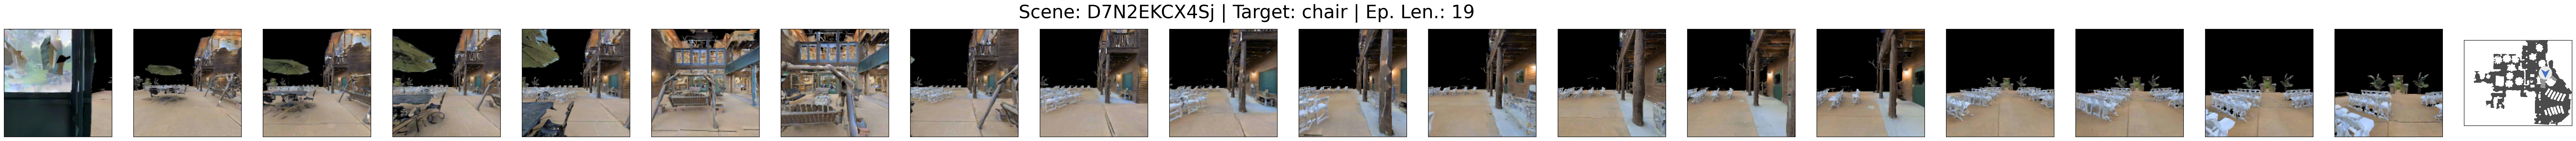

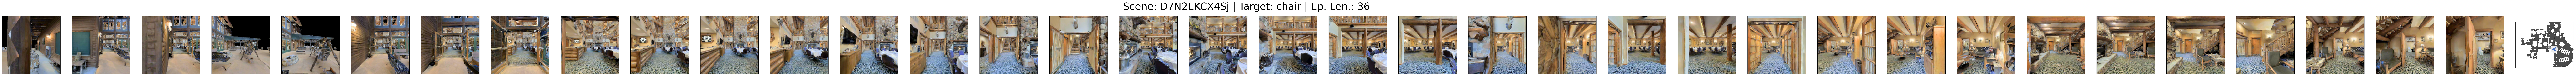

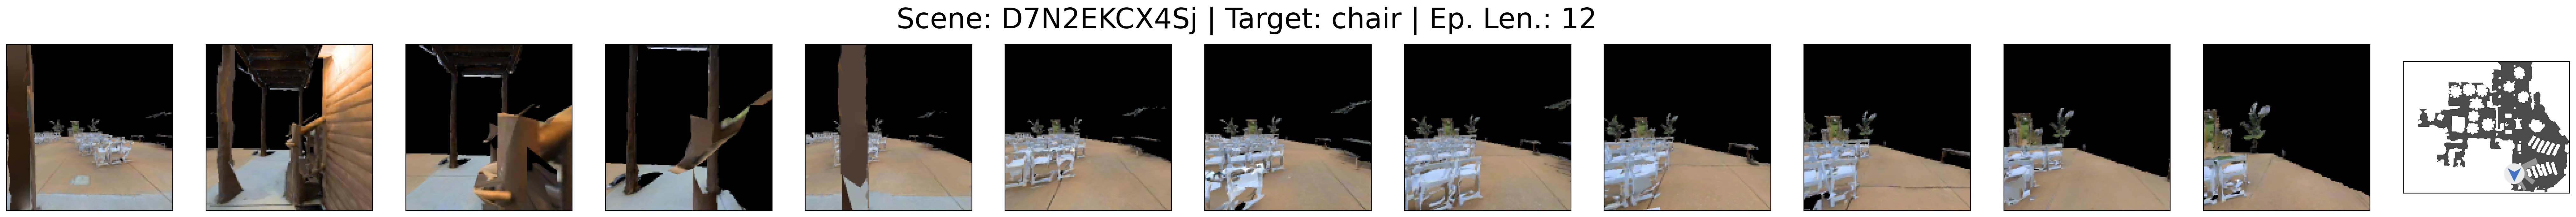

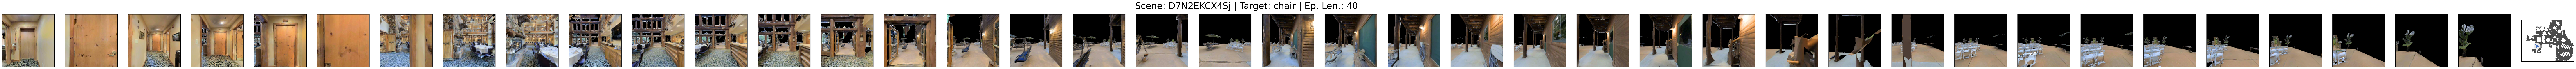

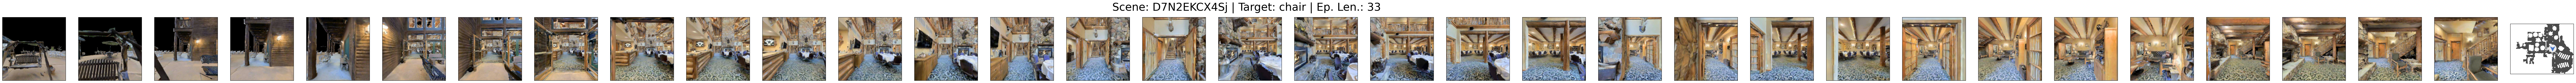

In [30]:
## Inspecting the analysis data trajectories, scene focused
SCENES_OF_INTEREST = ["D7N2EKCX4Sj"]
CATEGORIES_OF_INTEREST = ["chair"]

n_plotted_trajs = 0
MM = 50
for i, (scene, scene_cats_trajs) in enumerate(scenes_cats_trajs_dict.items()):
    if scene not in SCENES_OF_INTEREST:
        continue

    for catname, cat_trajs in scene_cats_trajs.items():
        if catname not in CATEGORIES_OF_INTEREST:
            continue
        
        for traj_dict in cat_trajs:
            NN = 0

            ep_filename = traj_dict["ep_filename"]
            edd = traj_dict["edd"]
            ep_length = edd["ep_length"]

            if NN <= 0:
                truncated_obs_list = edd["obs_list"]["rgb"]
                truncated_top_down_map_list = edd["info_list"]
                N_COLS = ep_length + 1
            else:
                truncated_obs_list = edd["obs_list"]["rgb"][:NN] + edd["obs_list"]["rgb"][-NN:]
                truncated_top_down_map_list = edd["info_list"][:NN] + edd["info_list"][-NN:]
                N_COLS = NN * 2 + 1
            
            fig, axes = plt.subplots(1, N_COLS, figsize=((N_COLS) *  4, 4), dpi=200)
            fig.set_facecolor("white")
            
            # Plot NN * 2 steps + top down map
            for t, rgb_obs in enumerate(truncated_obs_list):
                axes[t].imshow(rgb_obs)
                axes[t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
            top_down_map_img = plot_top_down_map(edd["info_list"][1])
            axes[-1].imshow(top_down_map_img)
            axes[-1].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)

            # Plot NN * 2 top_down_map + one rgb_obs
            # for t, info_dict in enumerate(truncated_top_down_map_list):
            #     top_down_map_img = plot_top_down_map(info_dict)
            #     axes[t].imshow(top_down_map_img)
            #     axes[t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
            # axes[-1].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
            # axes[-1].imshow(truncated_obs_list[-1])

            fig.suptitle(f"Scene: {scene} | Target: {catname} | Ep. Len.: {edd['ep_length']}", fontsize=32)

            n_plotted_trajs += 1

            if n_plotted_trajs >= MM:
                break
        
        if n_plotted_trajs >= MM:
            break

In [22]:
## Inspecting the analysis data trajectories
CATEGORIES_OF_INTEREST = ["chair"]
SCENES_OF_INTEREST = ["D7N2EKCX4Sj"]
n_plotted_trajs = 0
MM = 50
for i, (cat_name, cat_scenes_trajs) in enumerate(analysis_trajs_dict.items()):
    if catname not in CATEGORIES_OF_INTEREST:
        continue
    
    for scene_id, scene_trajs in cat_scenes_trajs.items():
        if scene_id not in SCENES_OF_INTEREST:
            continue
        
        for traj_dict in scene_trajs:
            NN = 0

            ep_filename = traj_dict["ep_filename"]
            edd = traj_dict["edd"]
            ep_length = edd["ep_length"]

            if NN <= 0 or NN * 2 > ep_length:
                truncated_obs_list = edd["obs_list"]["rgb"]
                truncated_top_down_map_list = edd["info_list"]
                NN = ep_length
            else:
                truncated_obs_list = edd["obs_list"]["rgb"][:NN] + edd["obs_list"]["rgb"][-NN:]
                truncated_top_down_map_list = edd["info_list"][:NN] + edd["info_list"][-NN:]
            
            fig, axes = plt.subplots(1, NN * 2 + 1, figsize=((NN * 2 + 1) *  6, 6), dpi=200)
            fig.set_facecolor("white")
            
            # Plot NN * 2 steps + top down map
            for t, rgb_obs in enumerate(truncated_obs_list):
                axes[t].imshow(rgb_obs)
                axes[t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
            top_down_map_img = plot_top_down_map(edd["info_list"][1])
            axes[-1].imshow(top_down_map_img)
            axes[-1].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)

            # Plot NN * 2 top_down_map + one rgb_obs
            # for t, info_dict in enumerate(truncated_top_down_map_list):
            #     top_down_map_img = plot_top_down_map(info_dict)
            #     axes[t].imshow(top_down_map_img)
            #     axes[t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
            # axes[-1].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
            # axes[-1].imshow(truncated_obs_list[-1])

            fig.suptitle(f"Scene: {scene_id} | Target: {cat_name} | Ep. Len.: {edd['ep_length']}", fontsize=32)

            n_plotted_trajs += 1

            if n_plotted_trajs >= MM:
                break
        
        if n_plotted_trajs >= MM:
            break